# Initialization and Optimization

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/04-tensorflow-optim-init.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

In this notebook, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: **initialization** and **optimization**.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum, and Adam.


<br>

```{margin}
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: This notebook is based on [Tutorial 4: Optimization and Initialization](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html) (PyTorch). The adapted version here is published with kind permission of the author.
```

In [1]:
import random
import warnings

import tensorflow as tf
import tensorflow.keras as kr
import tensorflow_datasets as tfds

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline


warnings.simplefilter(action="once")
backend_inline.set_matplotlib_formats('svg')

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preliminaries

Throughout this notebook, we will use a deep fully connected network, similar to our previous tutorial. We will also again apply the network to FashionMNIST, so you can relate to the results in the previous notebook.

### Preprocessing

Start by loading and preprocessing the FashionMNIST dataset:

In [2]:
def transform_image(image, sample_mean, sample_std):
    """Flatten image and standardize pixel-wise over batch."""
    
    image = tf.cast(tf.reshape(image, (-1,)), tf.float32)
    return (image - sample_mean) / sample_std


# Load training data
FMNIST, FMNIST_info = tfds.load(
    'fashion_mnist', 
    data_dir='./data', 
    with_info=True, 
    shuffle_files=False
)
train_ds, test_ds = FMNIST['train'], FMNIST['test']

# Get pixel-wise sample statistics
images = tf.reshape(next(iter(train_ds.batch(60000)))['image'], (-1, 784))
images = tf.cast(images, tf.float32)
sample_mean = tf.reduce_mean(images, axis=0)
sample_std = tf.math.reduce_std(images, axis=0)

# Preprocess input data
train_ds = train_ds.map(lambda x: (transform_image(x['image'], sample_mean, sample_std), x['label']))
test_ds = test_ds.map(lambda x: (transform_image(x['image'], sample_mean, sample_std), x['label']))

# For all our analysis, we fix one batch
fixed_batch = next(iter(train_ds.batch(batch_size=4096)))

2022-08-20 03:15:23.585105: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

2022-08-20 03:15:36.818376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-20 03:15:36.819690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Shuffling data/fashion_mnist/3.0.1.incompleteHBRPOI/fashion_mnist-train.tfrecord*...:   0%|          | 0/60000…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteHBRPOI/fashion_mnist-test.tfrecord*...:   0%|          | 0/10000 …

Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


2022-08-20 03:16:31.175893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Note that we transform each image so that each pixel value is standardized over the batch values for that pixel. The normalization is designed to give us an expected mean of `0` and a standard deviation of `1` for each pixel across the whole sample. 
This will be particularly relevant for the discussion about initialization that we will look at below so we perform it here. 

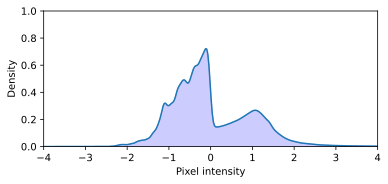

In [5]:
from scipy import stats

pixel_values = fixed_batch[0].numpy().reshape(-1)
fig, ax = plt.subplots(figsize=(6, 2.5))

K = stats.gaussian_kde(pixel_values)  # kernel
x = np.linspace(-4, 4, 300)

ax.fill_between(x, K(x), 0, color='blue', alpha=0.2)
ax.plot(x, K(x))
ax.set_xlim([-4, 4])
ax.set_ylim([ 0, 1])
ax.set_ylabel("Density")
ax.set_xlabel("Pixel intensity");

### Activation functions

For the activation functions, we make use of Keras' `activations` library instead of implementing ourselves. We also use `tf.identity` are our identity activation function. Although this activation function would significantly limit the network’s modeling capabilities, we will use it in the first steps of our discussion about initialization.

In [6]:
activations_by_name = {
    "tanh": kr.activations.tanh,
    "relu": kr.activations.relu,
    "id": tf.identity
}

### Base network

Next we define a function for instantiating a neural net. Here `activation` can be any TensorFlow callable function. In particular, functions in the `activations` library of Keras. The initializer in `kernel_initializer` is any valid layer weight initializer for Keras forward layers. In general, any callable that takes `shape` (of the weight tensor to initialize) and `dtype` (of initialized value) can be passed to this argument. 

In [7]:
def base_network(
    activation, 
    kernel_initializer,
    num_classes=10, 
    hidden_sizes=(512, 256, 256, 128)
):
    """Return a fully-connected network with given activation and layer widths."""

    # Add hidden layers with activation
    model = kr.Sequential()
    for j in range(len(hidden_sizes)):
        model.add(
            kr.layers.Dense(
                hidden_sizes[j],
                activation=activations_by_name[activation],
                kernel_initializer=kernel_initializer,
                bias_initializer='zeros'
            )
        )

    # Add linear logits layer
    model.add(
        kr.layers.Dense(
            units=num_classes,
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros'
        )
    )
    
    model.build(input_shape=(None, 784))
    
    return model

**Example:** Dense network with zero weights.

In [11]:
base_network('relu', kr.initializers.Zeros()).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               401920    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 10)                1290      
                                                                 
Total params: 633,226
Trainable params: 633,226
Non-trainable params: 0
_________________________________________________________________


### Plotting helper functions

Finally, we define a few helper functions for plotting distributions. These functions help us to visualize the gradients that the parameters at different layers receive, and the activations of the linear layers. The detailed code was hacked into existence based on the resulting visuals, but feel free to take a closer look if interested.

In [6]:
def plot_gradients_distribution(model, activation: str, color="C0", print_variance=False):
    """Plot histogram of gradients after one backprop from a batch of inputs."""

    # Get one batch of images
    images, labels = fixed_batch

    # Pass the batch through the network, and calculate the gradients for the weights
    loss_fn = kr.losses.SparseCategoricalCrossentropy(from_logits=True)
    with tf.GradientTape(persistent=True) as tape:
        preds = model(images)
        loss = loss_fn(labels, preds)

    # Exclude the bias to reduce the number of plots
    grads_dict = {}
    for i, layer in enumerate(model.layers):
        grads = tape.gradient(loss, layer.variables)

        # Get kernel weights
        for j in range(len(layer.variables)):
            w = layer.variables[j]
            if (not w.trainable) or ("bias" in w.name):
                continue
            grads_dict[i] = grads[j].numpy().reshape(-1)

    # Plotting
    grads_dict_ = {}
    max_n = max([len(grads_dict[k]) for k in grads_dict.keys()])

    for k in list(grads_dict.keys())[:-1]:
        data = grads_dict[k]
        data = np.concatenate([data, np.array([np.nan]*(max_n - len(data)))])
        if k < len(grads_dict) - 1:
            grads_dict_[f"({k+1}, dense)"] = data
        else:
            grads_dict_[f"logits"] = data

    _, ax = plt.subplots(1, 1, figsize=(10, 3))
    sns.violinplot(ax=ax, data=pd.DataFrame(grads_dict_), color=color, label=activation)
    ax.set_ylabel(r'${\nabla}_w L$')
    ax.legend([activation], loc='upper left')
    plt.show()

    # Print variances of each distribution
    if print_variance:
        for k in grads_dict_.keys():
            x = grads_dict_[k]
            print(f"{k:10} σ²_grad = {np.var(x[~np.isnan(x)]):.5e}")
    
    return grads_dict


def plot_activations_distribution(model, activation, color="C0", print_variance=False):
    """Plot activation density for output of each layer for one forward pass."""

    # We need to manually loop through the layers to save all activations
    images, _ = fixed_batch
    activations = {}
    for i, layer in enumerate(model.layers):
        if i == 0:
            activations[i] = layer(images)
        else:
            activations[i] = layer(activations[i-1])

    # Plotting. Skip input and classification layer
    max_n = max([len(activations[k].numpy().reshape(-1)) for k in activations.keys()])

    activations_ = {}
    for k in activations.keys():
        data = activations[k].numpy().reshape(-1)
        data = np.concatenate([data, np.array([np.nan]*(max_n - len(data)))])
        if k < len(activations) - 1:
            activations_[f"({k+1}, {activation})"] = data
        else:
            activations_[f"logits"] = data
    
    _, ax = plt.subplots(1, 1, figsize=(10, 3))
    sns.violinplot(ax=ax, data=pd.DataFrame(activations_), color=color, label=activation)
    ax.set_ylabel(r'${\phi}$')
    ax.tick_params(axis='x')
    plt.show()

    # Print variances of each distribution
    if print_variance:
        for k in activations_.keys():
            x = activations_[k]
            print(f"{k:10} σ²_act = {np.var(x[~np.isnan(x)]):.5e}")

    return activations

**Remark.** Observe that neurons in the hidden layers are identically distributed during initialization by symmetry. This allows us to combine all values in the `(B, m)` matrix into a histogram of `B * m` samples whose distribution should reflect the distribution of each individual output neuron. This is not true for neurons in the input and output layers which have different distributions, i.e. histogram plots for the input and output layers should be interpreted as an aggregated distribution which will generally differ from individual distributions of each neuron.

## Initialization

Training deep neural networks is essentially an optimization problem (in very high dimensions) with the network weights as parameters and the loss as objective. Thus, we have to choose initial values for the weights.
When initializing a neural network, there are a few properties we would like to have. 

First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.



In [7]:
model = base_network(activation='id', kernel_initializer='glorot_normal') # = linear transformation
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 633,226
Trainable params: 633,226
Non-trainable params: 0
_________________________________________________________________


To easily visualize various initialization schemes, we define the following helper function. Recall that the bias weights are initialized to zero in all subsequent discussion.

In [8]:
def visualize_initialization(
    activation,
    initialization,
    plot_grad=True, 
    plot_act=True, 
):
    """Helper function for visualizing different initialization schemes."""
    
    model = base_network(activation, initialization)
    gradients = {}
    activations = {}

    if plot_grad:
        gradients = plot_gradients_distribution(
            model, color="C1",
            print_variance=True,
            activation=activation,
        )
    if plot_act:
        activations = plot_activations_distribution(
            model, 
            activation=activation,
            color="C0", 
            print_variance=True,
        )

    return {
        'gradients': gradients,
        'activations': activations
    }

### Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value. Using a large constant will make the network have exploding activations since neurons accumulate the input vector into a weighted sum. What happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients. However, thinking a bit deeper, we see that setting all weights to some constant is not a good idea as the network will have trouble breaking symmetry between neurons.

```{margin}
Note that layers are **1-indexed**.
```

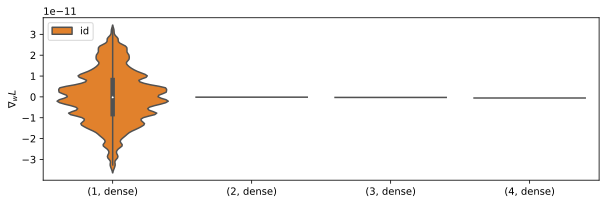

(1, dense) σ²_grad = 1.53186e-22
(2, dense) σ²_grad = 0.00000e+00
(3, dense) σ²_grad = 0.00000e+00
(4, dense) σ²_grad = 0.00000e+00


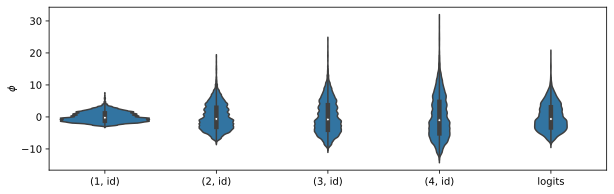

(1, id)    σ²_act = 2.43055e+00
(2, id)    σ²_act = 1.59289e+01
(3, id)    σ²_act = 2.60978e+01
(4, id)    σ²_act = 4.27587e+01
logits     σ²_act = 1.75140e+01


In [9]:
result = visualize_initialization(
    activation='id',
    initialization=kr.initializers.Constant(value=0.005),
)

As we can see, only the first and the last layer have diverse gradient distributions each intermediate hidden layers have the same gradient for all weights (note that this value is unequal to 0, but very close to it). Due to symmetry, all intermediate neurons belonging to the same layer will be equivalent, and therefore have the same gradient update so that `σ²_grad=0.0`, essentially reducing the effective number of parameters to 1 for these layers. 

The only sources of assymetry are the inputs and outputs, which explains the nonzero variance in the gradients of the first and last layers. For example, pixels in the edge of input images have different distributions with pixels on the center.

### Constant variance


From the experiment above, we have seen that a constant value is not working. So to break symmetry, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let’s implement it below, and visualize the activation distribution across layers.

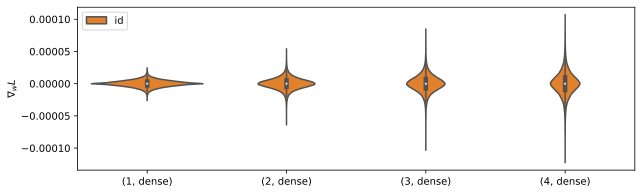

(1, dense) σ²_grad = 2.61554e-11
(2, dense) σ²_grad = 7.47508e-11
(3, dense) σ²_grad = 1.63786e-10
(4, dense) σ²_grad = 3.14494e-10


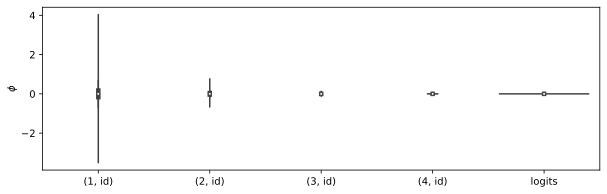

(1, id)    σ²_act = 7.69484e-02
(2, id)    σ²_act = 3.94326e-03
(3, id)    σ²_act = 9.83909e-05
(4, id)    σ²_act = 2.63551e-06
logits     σ²_act = 3.31104e-08


In [10]:
result = visualize_initialization(
    activation='id',
    initialization=kr.initializers.RandomNormal(0, stddev=0.01),
)

The variance of the activation becomes smaller and smaller across layers and almost vanishes in the last layer. Alternatively, we could use a higher standard deviation:


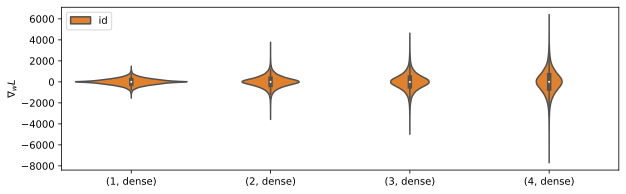

(1, dense) σ²_grad = 9.50059e+04
(2, dense) σ²_grad = 2.80250e+05
(3, dense) σ²_grad = 5.85746e+05
(4, dense) σ²_grad = 1.19722e+06


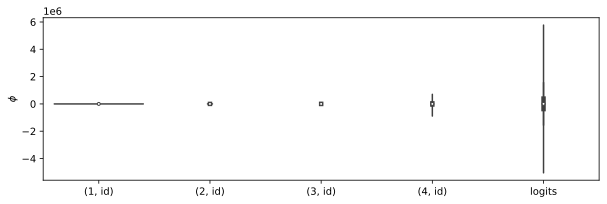

(1, id)    σ²_act = 4.88286e+02
(2, id)    σ²_act = 1.59816e+05
(3, id)    σ²_act = 2.61279e+07
(4, id)    σ²_act = 4.54931e+09
logits     σ²_act = 3.91087e+11


In [11]:
result = visualize_initialization(
    activation='id', 
    initialization=kr.initializers.RandomNormal(stddev=0.8),
)

With a higher standard deviation, the activations are likely to explode. We also get vanishing gradients. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended!

### How to find appropriate initialization values

Suppose we want to design an initialization for the linear layer which computes $\mathbf y= \boldsymbol x \boldsymbol W + \boldsymbol b$ with $\mathbf y\in\mathbb{R}^{n_{\mathbf y}}$ and $\boldsymbol x\in\mathbb{R}^{n_{\boldsymbol x}}$. From our experiments above, we saw that we need to optimally sample weights to ensure healthy distribution of activation values. For this, we state two requirements: 

1. The mean of the activations should be zero.
2. The variance of the activations should stay the same across every layer. 

Note that the activation neurons in a layer are identically distributed as a consequence of symmetry in the MLP network and the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) (CLT), so we can write the variance as $\sigma_{\mathbf y}^{2} = \mathbb V(\mathbf{y}_j).$ It follows that $\boldsymbol b = \boldsymbol 0$ since the bias is constant across different inputs. Next, it makes sense to set the mean of the weights to zero for the sake of symmetry. This also means that we only have to calculate the variance which can be done as follows:

$$\begin{split}
    \sigma_{\mathbf y}^{2} = \mathbb V(\mathbf{y}_j) & = \mathbb V\left(\sum_{i} \boldsymbol{x}_{i}\boldsymbol{W}_{ij}\right)\\
    & = \sum_{i}\ \mathbb V(\boldsymbol{x}_{i}\boldsymbol{W}_{ij})\\
    & = \sum_{i}\ \mathbb V(\boldsymbol{x}_{i}) \,\mathbb V(\boldsymbol{W}_{ij})\\
    & = n_{\boldsymbol x}\,\mathbb V(\boldsymbol{x}_{i})\,\mathbb V(\boldsymbol{W}_{ij}) = n_{\boldsymbol x}\, \sigma_{\boldsymbol x}^{2} \,\sigma_{\boldsymbol W}^2.
\end{split}
$$

Since the columns of $\boldsymbol W$ are independent of each other, the second line follows from the variance of the sum of independent random variables. On the other hand, the third line follows from the variance of a product of two independent random variables with zero mean. See [here](https://muchomas.lassp.cornell.edu/8.04/Lecs/lec_statistics/node14.html) and [here](https://stats.stackexchange.com/questions/52646/variance-of-product-of-multiple-independent-random-variables). Note that $\boldsymbol x$ also has zero mean  by the inductive hypothesis. Finally, we get the last equality since each $\boldsymbol{x}_i$ and $\boldsymbol{W}_{ij}$ are identically distributed.

**Remark.** As a technical aside, note that while the layers have identical and distributions, and zero mean, the input layer does not. This is not a huge issue, since all analysis can start in the hidden layers, where neurons have approximately zero mean and identical distributions by CLT. Note that CLT only works since each neuron in the input layer has approximately zero mean by our preprocessing methodology.

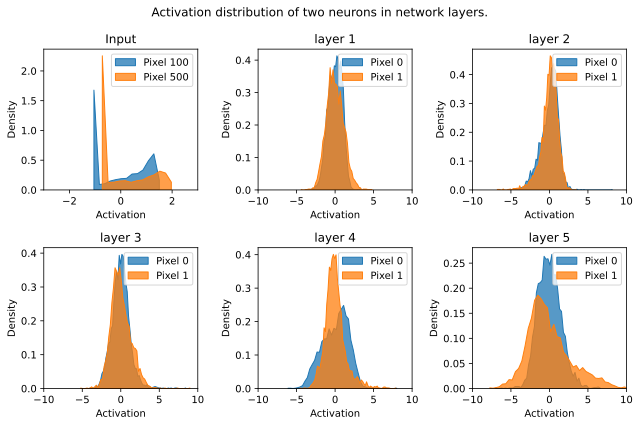

In [12]:
model = base_network(activation='id', kernel_initializer='glorot_normal') # = linear transformation
prep_inputs, _ = fixed_batch
activations = {0: prep_inputs}
x = prep_inputs
for i, layer in enumerate(model.layers):
    x = layer(x)
    activations[i + 1] = x

# Plot activations distribution for different pixels
cols = 3
fig, ax = plt.subplots(2, cols, figsize=(cols*3, 6.0))

for k in sorted(activations.keys()):
    # For input layer, we choose pixels on different local regions of the image.
    # For hidden layers, all pixels are iid, so we can choose adjacent neurons.
    if k == 0:
        p1, p2 = 100, 500 # pixel indices
    else:
        p1, p2 = 0, 1
        
    axk = ax[k // cols, k % cols]
    sns.histplot(activations[k].numpy()[:, p1], ax=axk, color=f"C0", stat='density', element='poly', label=f'Pixel {p1}') 
    sns.histplot(activations[k].numpy()[:, p2], ax=axk, color=f"C1", stat='density', element='poly', label=f'Pixel {p2}')
    axk.set_xlabel("Activation")
    if k == 0:
        axk.set_title("Input")
        axk.set_xlim(-3, 3)
    else:
        axk.set_title(f"layer {k}")
        axk.set_xlim(-10, 10)
    axk.legend()

plt.suptitle("Activation distribution of two neurons in network layers.")
fig.tight_layout();

Going back to the derivation, it follows that to get $\sigma^2_{\mathbf y} = \sigma^2_{\boldsymbol x},$ we must have $\sigma_{\boldsymbol W}^2 = \frac{1}{n_{\boldsymbol x}}.$ That is, we should initialize the weight distribution with a variance equal to the inverse of the layer's input dimension or number of fan-in neurons. Let's implement this below and check whether we get better results:

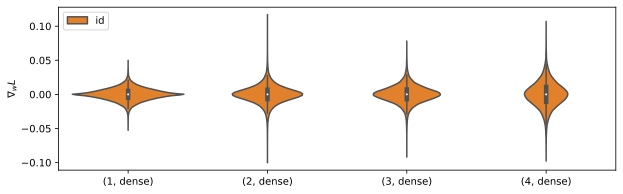

(1, dense) σ²_grad = 7.81915e-05
(2, dense) σ²_grad = 1.60997e-04
(3, dense) σ²_grad = 1.55216e-04
(4, dense) σ²_grad = 3.30697e-04


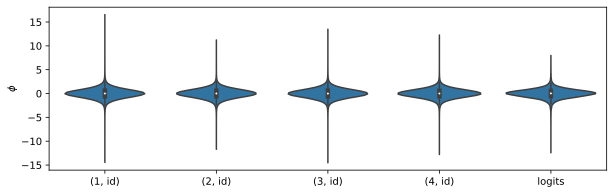

(1, id)    σ²_act = 9.70865e-01
(2, id)    σ²_act = 9.49525e-01
(3, id)    σ²_act = 9.53343e-01
(4, id)    σ²_act = 8.84497e-01
logits     σ²_act = 8.77540e-01


In [13]:
def xavier_fanin(shape, dtype=None):
    fan_in = shape[0]
    return kr.initializers.RandomNormal(0, stddev=1/np.sqrt(fan_in))(shape)

result = visualize_initialization(
    activation='id', 
    initialization=xavier_fanin,
)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of $0$ and variance of $\frac{1}{n_{\boldsymbol x}}.$ You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

In the above plot, we see that gradients slightly vanish nearer the inputs. Indeed, besides the variance of the activations, another variance we would like to stabilize is the one of the gradients.  This ensures a stable optimization for deep networks. From our work on backpropagation on MLPs, we know that
$\frac{\partial \mathcal L}{\partial \boldsymbol x} = \frac{\partial \mathcal L}{\partial \mathbf y} \boldsymbol W^\top.$
Hence
$\sigma^2_{\boldsymbol W^\top} = \sigma^2_{\boldsymbol W} = \frac{1}{n_\mathbf y}.$
As a compromise between both constraints, in [[Glorot and Bengio (2010)]](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi) the authors proposed to use the harmonic mean of both values. This leads us to the well-known **Xavier initialization**. For a normal distribution of initial weights, this looks like:

$$\boldsymbol W\sim \mathcal{N}\left(\mu = 0,\sigma^2=\frac{2}{n_{\boldsymbol x}+n_{\mathbf y}}\right).$$

If we use a uniform distribution, we initialize the weights with:

$$\boldsymbol W\sim U\left[-\frac{\sqrt{6}}{\sqrt{{n_{\boldsymbol x}+n_{\mathbf y}}}}, \frac{\sqrt{6}}{\sqrt{{n_{\boldsymbol x}+n_{\mathbf y}}}}\right].$$

Let's shortly implement it and validate its effectiveness:

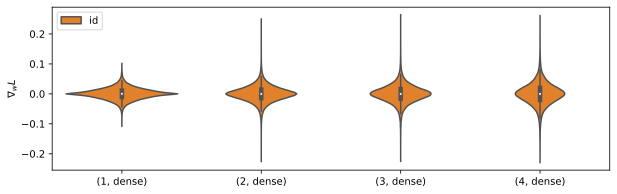

(1, dense) σ²_grad = 3.59411e-04
(2, dense) σ²_grad = 6.70388e-04
(3, dense) σ²_grad = 8.85401e-04
(4, dense) σ²_grad = 1.26921e-03


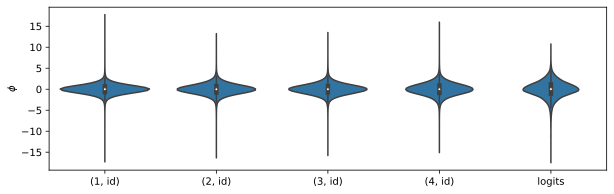

(1, id)    σ²_act = 1.20810e+00
(2, id)    σ²_act = 1.59252e+00
(3, id)    σ²_act = 1.57610e+00
(4, id)    σ²_act = 2.12880e+00
logits     σ²_act = 3.64181e+00


In [14]:
def xavier(shape, dtype=None):
    fan_in, fan_out = shape
    fan_avg = 0.5 * (fan_in + fan_out)
    init = kr.initializers.RandomNormal(0, stddev=np.sqrt(1/fan_avg))
    return init(shape)

result = visualize_initialization(
    activation='id',
    initialization=xavier,
)

We see that the Xavier initialization makes the variance of gradients and activations consistent across layers (`σ²_act` around `2` and `σ²_grad` around `1e-3`). Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension (128 vs 10), so that both `fan_in` and `fan_out` differs significantly from `fan_avg`.

#### Initialization for Tanh networks

In the discussions above, we assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the $\tanh$ works as a linear function such that we don’t have to adjust our calculation. We can check if that is the case for us as well.

Observe that accumulation of activation values with large weights pushes $\tanh$ activations to $\pm 1$ which likewise will continue to the rest of the network's layers. This limits the expressivity of the network.

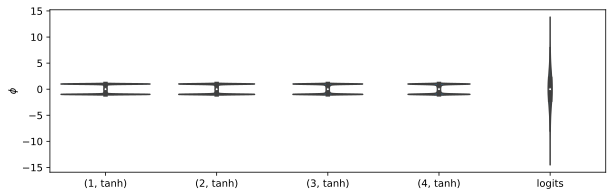

(1, tanh)  σ²_act = 8.92181e-01
(2, tanh)  σ²_act = 8.78982e-01
(3, tanh)  σ²_act = 8.26687e-01
(4, tanh)  σ²_act = 8.21610e-01
logits     σ²_act = 9.04456e+00


In [15]:
visualize_initialization(
    activation='tanh',
    initialization=kr.initializers.RandomNormal(0, stddev=0.3),
    plot_grad=False
);

For small fixed $\sigma,$ we get similar behavior with the identity network since for small input, $\tanh x \approx x.$ Thus, we get vanishing activations.

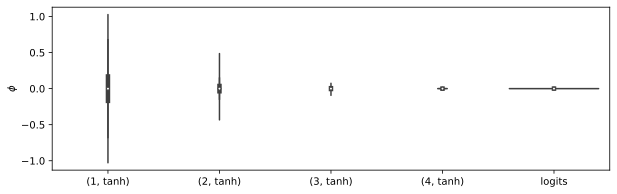

(1, tanh)  σ²_act = 6.43426e-02
(2, tanh)  σ²_act = 3.28973e-03
(3, tanh)  σ²_act = 8.34947e-05
(4, tanh)  σ²_act = 2.18588e-06
logits     σ²_act = 2.60761e-08


In [16]:
visualize_initialization(
    activation='tanh',
    initialization=kr.initializers.RandomNormal(0, stddev=0.01),
    plot_grad=False,
);

Let's try to initialize with Xavier normalization. This should work fairly well since $\tanh$ is approximately linear between -1 and 1. Indeed, observe that we get healthier activation distribution compared to initializing the weights with constant variance above!

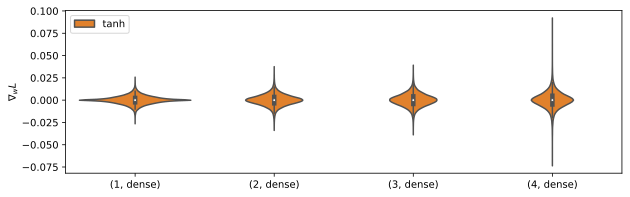

(1, dense) σ²_grad = 2.13943e-05
(2, dense) σ²_grad = 3.90283e-05
(3, dense) σ²_grad = 5.02256e-05
(4, dense) σ²_grad = 8.22868e-05


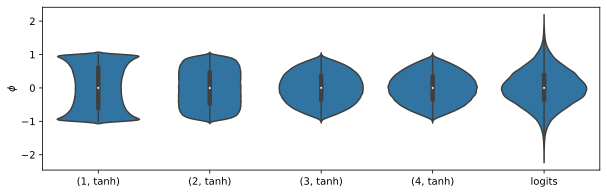

(1, tanh)  σ²_act = 4.02001e-01
(2, tanh)  σ²_act = 2.85989e-01
(3, tanh)  σ²_act = 1.92777e-01
(4, tanh)  σ²_act = 1.81763e-01
logits     σ²_act = 2.79316e-01


In [17]:
result = visualize_initialization(
    activation='tanh',
    initialization=xavier,
)

#### Initialization for ReLU networks

But what about ReLU networks? Here, we cannot take the previous assumption of the non-linearity becoming linear for small values.  Suppose $\mathbf y = \boldsymbol x\boldsymbol W$ such that $\boldsymbol x$ is an output of a ReLU activated layer. So $\boldsymbol x$ is not any more zero-centered. But as long as the expectation of $\boldsymbol W$ is zero and $\boldsymbol b= \boldsymbol 0$, the expectation of the output is zero, so we still have mean zero for $\mathbf y.$ Here our goal is for preactivations to have constant variance and zero mean as this should result in controlled activations. For the latter requirement, the part where the calculation of the ReLU initialization differs from the identity is when determining:

$$
\mathbb V(\boldsymbol{x}_{i} \boldsymbol{W}_{ij} ) = 
\underbrace{\mathbb{E}[{\boldsymbol{x}_{i}}^2]}_{\mathbb V(\boldsymbol{x}_i)} \;
\underbrace{\mathbb{E} [ {\boldsymbol{W}_{ij}}^2 ]}_{\mathbb V(\boldsymbol{W}_{ij})}
-
\mathbb{E}[ \boldsymbol{x}_{i} ]^2 \; \underbrace{\mathbb{E}[\boldsymbol{W}_{ij}]^2}_{= 0}
= \mathbb{E}[{\boldsymbol{x}_{i}}^2] \; \mathbb V(\boldsymbol{W}_{ij}).
$$

If we assume now that $\boldsymbol x$ is the output of a ReLU activation, we can calculate the expectation as follows. In the first equality, $\rho$ is the probability distribution of the values of the preactivation neuron $z_i$ that outputs $x_i.$ We can assume that $\rho$ is symmetric around zero by the inductive hypothesis. Thus

$$
\begin{split}
\mathbb{E}[{\boldsymbol{x}_i}^2] 
&= \int_{-\infty}^{\infty} \max(0, {a})^2 \rho({a})\, d{a} \\
&= \int_0^{\infty} {a}^2 \rho({a})\, d{a} = \frac{1}{2}\int_{-\infty}^{\infty} {a}^2 \rho({a})\, d{a} = \frac{1}{2}\mathbb V(\boldsymbol{z}_i).
\end{split}$$


It follows that 

$$\sigma^2_{\mathbf y} = \frac{1}{2}\sum_{j} \sigma^2_{\boldsymbol W}\, \sigma^2_{ {\boldsymbol{z}}}= \frac{1}{2}\, n_{\boldsymbol{x}}\, \sigma^2_{\boldsymbol W}\, \sigma^2_{\boldsymbol{z}}.$$ 

Hence, our desired weight variance becomes $\sigma^2_{\boldsymbol W} = \frac{2}{n_{\boldsymbol x}}.$
This is known as **Kaiming initialization**. Note that Kaiming initialization does not use the harmonic mean between input and output size. It turns out that using $n_{\boldsymbol x}$ or $n_{\mathbf y}$ both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network. Hence, we can use only the input $n_{\boldsymbol x}.$

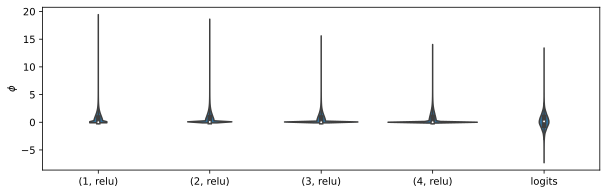

(1, relu)  σ²_act = 6.98994e-01
(2, relu)  σ²_act = 7.78067e-01
(3, relu)  σ²_act = 7.22222e-01
(4, relu)  σ²_act = 9.11374e-01
logits     σ²_act = 1.64040e+00


In [18]:
def kaiming(shape, dtype=None):
    fan_in, fan_out = shape
    init = kr.initializers.RandomNormal(0, stddev=np.sqrt(2/fan_in))
    return init(shape)

result = visualize_initialization(
    activation='relu',
    initialization=kaiming,
    plot_grad=False,
)

In contrast, having no factor of 2 results in vanishing activation values. The activation variance becomes  unstable across layers. 

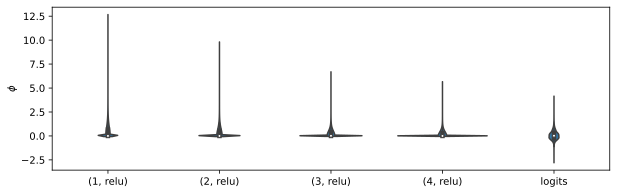

(1, relu)  σ²_act = 4.19603e-01
(2, relu)  σ²_act = 2.67133e-01
(3, relu)  σ²_act = 1.32432e-01
(4, relu)  σ²_act = 9.52388e-02
logits     σ²_act = 2.03516e-01


In [19]:
visualize_initialization(
    activation='relu',
    initialization=xavier,
    plot_grad=False,
);

We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for other activations we have to slightly adjust the factor in the variance. For instance, for LeakyReLU half of the values are not set to zero anymore, and calculating a similar integral as above results in a factor of $\frac{2}{1 + \alpha^2}$ instead of $2$ for the ReLU.

```{note}
To initialize with different scale factors, Keras implements the `VarianceScaling` initializer which samples weights from a normal distribution with mean zero and standard deviation `stddev = sqrt(scale/n)` where `n` depends on the `mode` with `'fan_in'`, `'fan_out'`, and `'fan_avg'` as possible values. In particular, Kaiming corresponds to `scale=2` and `mode='fan_in'`. Xavier corresponds to `scale=1` and `mode='fan_avg'`. Note that same with other normal initializers, Keras truncates the sample space to prevent initializing too large weights. 
```

### Understanding activation and gradient flow

Suppose we index layers and weights as in {numref}`neuralnet-layers` with $\boldsymbol x_0$ as input data. It follows that $\sigma_{\boldsymbol{x}_{t+1}}^{2} = \sigma_{\boldsymbol{x}_{t}}^{2}\,n_{\boldsymbol{x}_{t}}\, \sigma_{\boldsymbol W_t}^2$  for $t \geq 1.$ Thus, applying the formula recursively, we get


$$\sigma_{\boldsymbol{x}_{t}}^{2} =  \sigma_{\boldsymbol{x}_{1}}^{2} \left(\prod_{k=1}^{t-1} n_{\boldsymbol{x}_k}\,\sigma_{\boldsymbol W_k}^2\right)$$ 

for $t \geq 1.$ This formula explains why activations and gradients blow up as we go deeper into the layers for a network initialized with sufficiently large constant variance for the weights, and vanishes with depth for sufficiently small constant variance. For example, $\sigma_{\boldsymbol W_k}^2 = \frac{1}{n_{\boldsymbol{x}_{k}}}$ in Xavier initialization, so that $\sigma_{\boldsymbol{x}_{t}}^{2} = \sigma_{\boldsymbol{x}_{1}}^{2}.$ Note that we have the same equation for gradients but in the reverse direction (starting from the logits layer) which motivates fan-out Xavier initialization.

```{figure} ../../img/neuralnet-layers.png
---
width: 30em
name: neuralnet-layers
---
Schematic diagram of a feedforward neural network. 
```

Note that this equation is only an approximation for actual networks since neurons are only approximately independent and identically distributed, and also only have approximately zero mean. But we will test whether our computations are consistent at least in order of magnitude. Recall the identity network initialized with constant variance $\sigma = 0.8$ had exploding activations while for $\sigma=0.01$ it had vanishing activations.

In [20]:
def test_activation_formula(std):
    model = base_network(
        activation='id', 
        kernel_initializer=kr.initializers.RandomNormal(stddev=std)
    )
    activations = {0: fixed_batch[0]}
    for i, layer in enumerate(model.layers):
        activations[i + 1] = layer(activations[i])

    for i in range(1, 5):
        v1 = activations[i].numpy().std() ** 2
        v2 = activations[i+1].numpy().std() ** 2
        print((activations[i].shape[1] * v1 * (std)**2, v2))
    

# Testing for exploding activations
test_activation_formula(std=0.8)

(158170.74445490958, 156471.62286973)
(25636310.690976568, 25327737.05425358)
(4149696438.968907, 4118834736.8657837)
(337414941644.04504, 332312112399.41016)


In [21]:
# Testing for vanishing activations
test_activation_formula(std=0.01)

(0.004034352758576279, 0.003939023711409251)
(0.00010083900701207682, 0.0001028426230109689)
(2.632771149080804e-06, 2.707619918953261e-06)
(3.465753496260174e-08, 2.7301971702122963e-08)


For the input layer $\boldsymbol x_1 = \boldsymbol x_0 \boldsymbol W_0,$ we get $\frac{\partial \mathcal L}{\partial \boldsymbol W_0} = {\boldsymbol x_0^\top} \frac{\partial \mathcal L}{\partial \boldsymbol x_1}$ by backpropagating from $\boldsymbol x_1$ to $\boldsymbol W_0.$ Similarly, we can backpropagate from $\boldsymbol x_2$ to $\boldsymbol x_1$ in the next layer $\boldsymbol x_2 = \boldsymbol x_1 \boldsymbol W_1$ to get
$\frac{\partial \mathcal L}{\partial \boldsymbol x_1} = \frac{\partial \mathcal L}{\partial \boldsymbol x_2} \boldsymbol W_1^\top.$

Continuing this process, we get the weight gradient of the input layer in terms of the weight gradients of the logits layer $\boldsymbol x_5$ (which we have easy access to):

$$\frac{\partial \mathcal L}{\partial \boldsymbol W_0} = {\boldsymbol x_0^\top} \frac{\partial \mathcal L}{\partial \boldsymbol x_5} (\boldsymbol W_1\boldsymbol W_2 \boldsymbol W_3 \boldsymbol W_4)^\top$$

Shifting the starting point to get the gradient of any intermediate layer of the network:

$$\frac{\partial \mathcal L}{\partial \boldsymbol W_t} = {\boldsymbol x_t^\top} \frac{\partial \mathcal L}{\partial \boldsymbol x_d}\left( \boldsymbol{W}_{t+1} \ldots \boldsymbol{W}_{d-1} \right)^\top$$ 

where $0 \leq t \leq d-1.$ Notice the stack of weight matrices. This product can explode or vanish depending on the magnitude of the weights. From this formula, we can see why there is vanishing gradients with exploding activations for the identity network initialized with $\sigma_{ \boldsymbol{W}_{k}} = 0.8.$ Since the activations explode, shallower layers have lower activations, hence get lower weight gradients because of the factor ${\boldsymbol x_t^\top}.$ Moreover the entries of the weights product approaches zero.

**Remark.** The formula is similar for general nonlinear activations, but involves the derivative of the activation multiplied (or broadcasted) to the respective weight matrix, so we expect similar behavior for the general case.

<!-- To further check for correctness, we implement the formula for $\frac{\partial \mathcal L}{\partial \boldsymbol W_t}$ in code as follows: -->

<!-- def weights_gradient_formula(t, model):
    """Formula for computing gradient as a product of weights."""
    
    # Compute activations; here we are careful about indexing
    inputs, targets = fixed_batch
    acts_dict = {}
    x = inputs
    acts_dict[0] = x.numpy() # x0 = input
    for layer_index, layer in enumerate(model.layers):
        x = layer(x)
        acts_dict[layer_index + 1] = x.numpy() # x1 = x0 W0, etc.

    # Compute gradients of logits
    loss_fn = kr.losses.SparseCategoricalCrossentropy(from_logits=True)
    with tf.GradientTape(persistent=True) as tape:
        preds = model(inputs)
        loss = loss_fn(targets, preds)
    preds_grad = tape.gradient(loss, preds).numpy()

    # Compute return value
    X = acts_dict[t]
    weights = [h.get_weights()[0] for h in model.layers]
    if t > len(weights) - 1:
        raise IndexError
    else:
        import functools
        return functools.reduce(
            lambda x, y: x @ y.T, 
            weights[len(weights) - 1: t: -1], # Right multiply weights starting from index 0
            X.T @ preds_grad # Initial factor
        )


def weights_gradient_autodiff(model):
    """Compute gradients using autodifferentiation."""

    images, labels = fixed_batch
    loss_fn = kr.losses.SparseCategoricalCrossentropy(from_logits=True)
    grads_dict = {}
    with tf.GradientTape(persistent=True) as tape:
        loss = loss_fn(labels, model(images))

    for layer_index, layer in enumerate(model.layers):
        grads = tape.gradient(loss, layer.variables[0])
        grads_dict[layer_index] = grads.numpy()

    return grads_dict -->

<!-- Testing if the above formula works: -->

<!-- # Fix model
model = base_network(
    activation=None,
    kernel_initializer=xavier,
    hidden_sizes=[512, 256, 256, 128]
)
model.build(input_shape=(None, 784))

# Compute errors for each layer
errors = []
grads_dict = weights_gradient_autodiff(model)
for t in grads_dict.keys():
    W_grad = weights_gradient_formula(t, model)
    e = np.abs(W_grad - grads_dict[t]).max() / np.abs(grads_dict[t]).mean()
    errors.append(e)

plt.plot([str(k) for k in grads_dict.keys()], errors) # force int xticks
plt.xlabel('layer no.')
plt.ylabel('max abs. relative error'); -->

## Optimization

Besides initialization, selecting a suitable optimization algorithm can be an important choice for deep neural networks. First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function ${\mathbf w}^{(t)} = f({\mathbf w}^{(t-1)}, {\mathbf g}^{(t)}, ...)$ with $\mathbf w$ being the parameters, and ${\mathbf g}^{t} = \nabla_{{\mathbf w}^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps. 

### Optimization algorithms

As most optimizers only differ in the implementation of the functional dependence $f$ of the gradients and the current parameters, we can define a template for an optimizer below. We take as input the parameters of a model and a learning rate. The `step()` function tells the optimizer to update all weights based on their gradients.

In [22]:
class OptimizerTemplate:
    def __init__(self, model, learning_rate):
        self.model = model
        self.learning_rate = learning_rate

    def step(self, grads):
        for w, g in zip(self.model.trainable_variables, grads):
            self.update_param(w, g)
    
    def update_param(self, weight, grad):
        raise NotImplementedError

#### SGD

The first optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD). SGD updates the parameters using the following equation:

$$
\begin{split}
    {\mathbf w}^{(t)} & = {\mathbf w}^{(t-1)} - \eta\, {\mathbf g}^{(t)}.
\end{split}
$$

Let's implement this in the following class:

In [23]:
class SGD(OptimizerTemplate):
    def __init__(self, model, learning_rate):
        super().__init__(model, learning_rate)

    def update_param(self, weight, grad):
        dw = -self.learning_rate * grad
        weight.assign_add(dw)

#### SGD with Momentum

SGD can be improved using the concept of **momentum** which replaces the gradient in the update by an exponential average of all past gradients including the current one:

$$
\begin{split}
    \mathbf{m}^{(t)} & = \beta_1 \mathbf{m}^{(t-1)} + (1 - \beta_1)\, {\mathbf g}^{(t)}\\
    {\mathbf w}^{(t)} & = {\mathbf w}^{(t-1)} - \eta\, \mathbf{m}^{(t)}.\\
\end{split}
$$

Momentum help smooth out gradient updates. This can be helpful when dealing with oscillating updates. 

In [24]:
class SGDMomentum(OptimizerTemplate):
    def __init__(self, model, learning_rate, momentum=0.0):
        super().__init__(model, learning_rate)
        self.beta = momentum
        self.m = {w.name: tf.zeros_like(w) for w in model.trainable_variables}

    def update_param(self, weight, grad):
        self.m[weight.name] = self.beta * self.m[weight.name] + (1 - self.beta) * grad
        dw = -self.learning_rate * self.m[weight.name]
        weight.assign_add(dw)

#### Adam

Finally, we arrive at Adam. Adam combines the idea of momentum with an adaptive learning rate, which is based on an exponential average of the squared gradients, i.e. the gradients norm. Furthermore, we add a bias correction for the momentum and adaptive learning rate for the first iterations:

$$
\begin{split}
    {\mathbf{m}}^{(t)} & = \beta_1 {\mathbf{m}}^{(t-1)} + (1 - \beta_1)\, {\mathbf g}^{(t)}\\
    {\mathbf{v}}^{(t)} & = \beta_2 \,{\mathbf{v}}^{(t-1)} \,+ (1 - \beta_2)\, {\mathbf g}^{(t)} \odot {\mathbf g}^{(t)}\\
    \hat{{\mathbf{m}}}^{(t)} &= \frac{{\mathbf{m}}^{(t)}}{1-{\beta_1}^{t}}, \quad \hat{{\mathbf{v}}}^{(t)} = \frac{{\mathbf{v}}^{(t)}}{1-{\beta_2}^{t}}\\
    {\mathbf w}^{(t)} & = {\mathbf w}^{(t-1)} - \frac{\eta}{\sqrt{\hat{{\mathbf{v}}}^{(t)}} + \epsilon} \hat{\mathbf{m}}^{(t)}\\
\end{split}
$$

Here $\epsilon$ is a small constant used to improve numerical stability for very small gradient norms. Remember that the adaptive learning rate does not replace the learning rate hyperparameter $\eta,$ but rather acts as an extra factor and ensures that the gradients of various parameters have a similar norm. 

In [25]:
class Adam(OptimizerTemplate):
    def __init__(self, model, learning_rate, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(model, learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # (t = 0)
        self.m = {w.name: tf.zeros_like(w) for w in model.trainable_variables}
        self.v = {w.name: tf.zeros_like(w) for w in model.trainable_variables}
        self.param_step = {w.name: 0 for w in model.trainable_variables} # time steps for each variable

    def update_param(self, weight, grad):
        # fetch prev. momentum and second momentum
        self.m[weight.name] = self.beta1 * self.m[weight.name] + (1 - self.beta1) * grad
        self.v[weight.name] = self.beta2 * self.v[weight.name] + (1 - self.beta2) * (grad ** 2)
        
        # bias correction
        self.param_step[weight.name] += 1
        t = self.param_step[weight.name]
        m_hat = self.m[weight.name] / (1 - self.beta1**t)
        v_hat = self.v[weight.name] / (1 - self.beta2**t)

        # update weights
        dw = -self.learning_rate * (m_hat / (tf.sqrt(v_hat) + self.eps))
        weight.assign_add(dw)

### Comparing optimizers on model training

After we have implemented three optimizers, we can start to analyze and compare them. 
First, we test them on how well they can optimize a neural network on the FashionMNIST dataset. We use again our linear network, this time with a ReLU activation and the Kaiming initialization, which we have found before to work well for ReLU-based networks. Note that the model is over-parameterized for this task, and we can achieve similar performance with a much smaller network. However, our main interest is in how well the optimizer can train *deep* neural networks, hence the over-parameterization.

In [26]:
from sklearn import metrics
from tqdm import tqdm

def train_model(model, optim, max_epochs=40, batch_size=256):
    # loss function
    loss_fn = kr.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Recall shuffle, batch, repeat pattern to create epochs
    train_loader = train_ds.shuffle(buffer_size=10000)
    train_loader = train_loader.batch(batch_size=batch_size, drop_remainder=True)
    train_loader = train_loader.repeat(max_epochs)
    train_loader = train_loader.prefetch(buffer_size=batch_size)    # Prepare next elements 
                                                                    # while current is preprocessed. 
                                                                    # Trades off latency with memory.
    valid_loader = test_ds.shuffle(buffer_size=4096)
    valid_loader = valid_loader.batch(2048)
    valid_loader = valid_loader.repeat()
    valid_iterator = iter(valid_loader)

    # training
    train_loss = []
    valid_loss = []
    valid_acc  = []
    step = 0
    for x_train, y_train in tqdm(train_loader):
        with tf.GradientTape() as tape:
            loss = loss_fn(y_train, model(x_train))

        grads = tape.gradient(loss, model.trainable_variables)
        optim.step(grads)
        train_loss.append(loss)

        # compute valid. loss and valid. accuracy
        if step % batch_size == 0:
            x_valid, y_valid = next(valid_iterator)
            valid_loss.append(loss_fn(y_valid, model(x_valid)))
            valid_acc.append(
                metrics.accuracy_score(
                    y_valid, 
                    model.predict(x_valid).argmax(axis=1)
                )
            )
        step += 1

    return {
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "valid_acc": valid_acc,
        "model": model
    }

For a fair comparison, we train the exact same model with the same initialization with the optimizers below. Listing all optimizers in a dictionary as a function of the model it attaches to. This can be easily extended with additional optimizers that we want to test:

In [27]:
optimizers = {
    'Adam': lambda model: Adam(model, learning_rate=1e-3),
    'SGD':  lambda model: SGD(model, learning_rate=1e-2),
    'SGDm': lambda model: SGDMomentum(model, learning_rate=1e-1, momentum=0.9),
}

model = base_network(
    activation='relu', 
    kernel_initializer='he_normal'
)

results = {}
for optim_name in optimizers.keys():
    model_ = kr.models.clone_model(model) # e.g. same init
    optim = optimizers[optim_name]
    results[optim_name] = train_model(model_, optim(model_), max_epochs=10, batch_size=256)

100%|██████████| 2340/2340 [00:57<00:00, 40.36it/s]


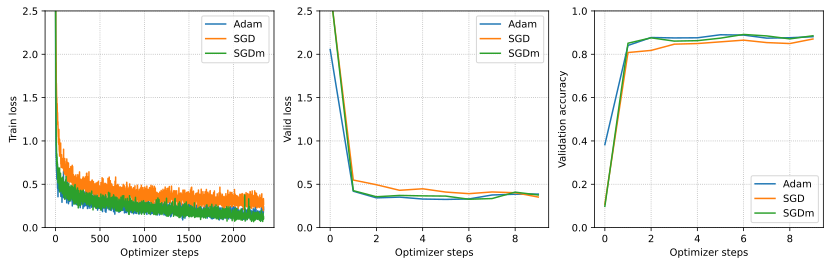

In [28]:
x = [256*i for i in range(len(results['Adam']['valid_loss']))]
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

targets = {
    0: {'target': 'train_loss', 'name': 'Train loss', 'max': 2.5},
    1: {'target': 'valid_loss', 'name': 'Valid loss', 'max': 2.5},
    2: {'target': 'valid_acc', 'name': 'Validation accuracy', 'max': 1.0}
}

for j in range(3):
    for i, optim_name in enumerate(optimizers.keys()):
        ax[j].plot(
            results[optim_name][targets[j]['target']], 
            color=f"C{i}", 
            label=optim_name, 
            zorder=2
        )

        ax[j].legend()
        ax[j].set_ylabel(targets[j]['name'])
        ax[j].set_xlabel("Optimizer steps")
        ax[j].set_ylim(0, targets[j]['max'])
        ax[j].grid(linestyle='dotted')
        ax[j].legend()

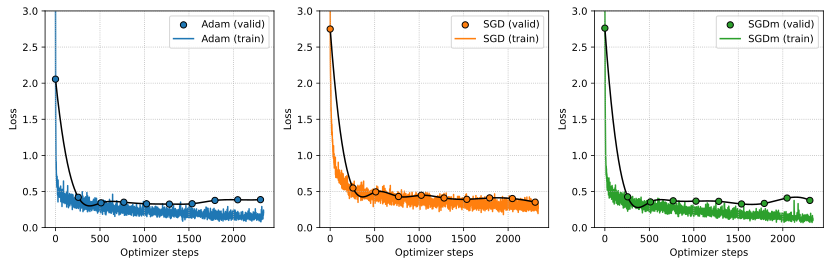

In [29]:
from scipy.interpolate import interp1d
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

for j, optim_name in enumerate(optimizers.keys()):
    ax[j].scatter(x, results[optim_name]['valid_loss'], color=f"C{j}", s=40, edgecolor='black', label=f"{optim_name} (valid)", zorder=3)
    f = interp1d(x, results[optim_name]['valid_loss'], kind='cubic') # interpolate: cubic
    ax[j].plot(range(2304), f(range(2304)), color=f"k", zorder=2)
    ax[j].plot(results[optim_name]['train_loss'], color=f"C{j}", label=f"{optim_name} (train)", zorder=1)
    ax[j].legend()
    ax[j].set_ylim(0, 3)
    ax[j].set_ylabel("Loss")
    ax[j].set_xlabel("Optimizer steps")
    ax[j].grid(linestyle='dotted')
    ax[j].legend();

Overall accuracy on the whole test set:

In [30]:
from sklearn.metrics import accuracy_score
X_test, y_test = next(iter(test_ds.batch(10000)))

print("Test accuracies:")
for optim_name in optimizers.keys():
    print(f"  {optim_name:10} {accuracy_score(y_test, results[optim_name]['model'].predict(X_test).argmax(axis=1))*100:.2f}%")

Test accuracies:
  Adam       87.93%
  SGD        86.58%
  SGDm       88.37%


### Testing optimizers on exotic surfaces

The result above is that all optimizers perform similarly well with the given model. The differences are too small to find any significant conclusion. However, keep in mind that this can also be attributed to the initialization we chose. When changing the initialization to worse (e.g. constant initialization), Adam usually shows to be more robust because of its adaptive learning rate. To show the specific benefits of the optimizers, we will continue to look at some possible loss surfaces in which momentum and adaptive learning rate are crucial.

#### Pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. Let’s first create an example surface of this and visualize it:

In [31]:
from matplotlib import cm

def plot_surface(f, title, ax, x_range=(-5, 5), y_range=(-15, 5), cmap=cm.viridis):

    # Plot surface on xy plane; choose 3d or 2d plot
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y).numpy()

    # Plot    
    ax.plot_surface(X, Y, Z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
    ax.set_zlabel("loss", rotation=90)
    
    # Formatting plot
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()

    return ax


def plot_contour(f, title, ax, x_range=(-5, 5), y_range=(-15, 5), cmap=cm.viridis):

    # Plot surface on xy plane; choose 3d or 2d plot
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y).numpy()
    
    # Plot
    ax.contourf(X, Y, Z)
    
    # Formatting
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()

    return ax

Consider the function below which has a long, narrow, parabolic shaped flat valley. In terms of optimization, you can image that $\mathsf{w}_1$ and $\mathsf{w}_2$ are weight parameters, and the curvature represents the loss surface over the space of $\mathsf{w}_1$ and $\mathsf{w}_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.


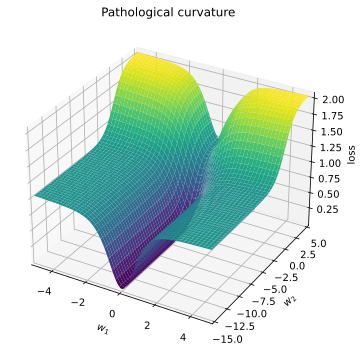

In [32]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, 
    # feel free to experiment here!
    x1_loss = kr.activations.tanh(w1)**2 + 0.01 * tf.abs(w1)
    x2_loss = kr.activations.sigmoid(w2)
    return x1_loss + x2_loss

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
plot_surface(pathological_curve_loss, title="Pathological curvature", ax=ax)
plt.show();

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $\mathsf{w}_2$. However, if we encounter a point along the ridges, the gradient is much greater in $\mathsf{w}_1$ than $\mathsf{w}_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [33]:
class OptimModel(kr.Model):
    def __init__(self, init):
        super().__init__()
        self.w1 = tf.Variable(init[0], name='w1', trainable=True)
        self.w2 = tf.Variable(init[1], name='w2', trainable=True)


def get_optimizer_path(optim_fn, init, loss_surface, num_steps=100):
    """
    Plots trajectory of optimizer from initial point (`init`) along 
    a surface (`loss_surface`) in minimizing it via gradient updates. 
    
    Return: list of 2-tuples which correspond to (x, y) coords of 
    the points in its trajectory."""

    model = OptimModel(init)
    optim = optim_fn(model)
    path = [model.get_weights()]
    losses = []

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            weights = model.trainable_variables
            loss = loss_surface(*weights)

        grads = tape.gradient(loss, weights)
        optim.step(grads)
        path.append(model.get_weights())
        losses.append(loss.numpy())

    return np.array(path), losses

Compute trajectories of gradient descent for the three optimizers starting from `(-5, 5)`:

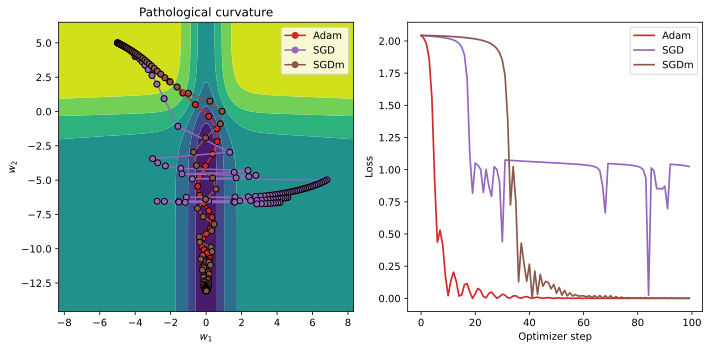

In [75]:
def plot_optimizer_path(optimizers, init, surface, surface_name, x_range=None, y_range=None):
    
    results = {}
    for optim_name in optimizers.keys():
        optim = optimizers[optim_name]
        path, losses = get_optimizer_path(optim, init, surface)
        results[optim_name] = {
            'path': path,
            'losses': losses
        }

    # Get ranges of coordinates of the optimization trajectories + padding
    # x = w1 and y = w2, i.e. see ordering on output of get_weights function
    all_points = np.concatenate([results[optim_name]['path'] for optim_name in optimizers.keys()], axis=0)
    if x_range is None:
        x_max = np.absolute(all_points[:, 0]).max()
        x_range = (-x_max - 1.5, x_max + 1.5)
        
    if y_range is None:
        y_range = (all_points[:, 1].min() - 1.5, all_points[:, 1].max() + 1.5)

    # Plot surface on box defined by coordinate ranges
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    plot_contour(
        surface, surface_name, 
        ax=ax[0], 
        x_range=x_range, 
        y_range=y_range,
    )

    # Plot trajectory of optimizers
    for i, optim_name in enumerate(optimizers.keys()):
        ax[0].plot(results[optim_name]['path'][:, 0], results[optim_name]['path'][:, 1], color=f"C{i+3}",  marker="o", zorder=1, label=optim_name)
        ax[0].scatter(results[optim_name]['path'][:, 0], results[optim_name]['path'][:, 1], color=f"C{i+3}",  edgecolor='k', zorder=1)
        ax[1].plot(results[optim_name]['losses'], label=optim_name, linewidth=1.7, color=f"C{i+3}")

    ax[0].legend()
    ax[1].legend()
    ax[1].set_xlabel("Optimizer step")
    ax[1].set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

    return results


optimizers = {
    'Adam': lambda model: Adam(model, learning_rate=1),
    'SGD':  lambda model: SGD(model, learning_rate=10),
    'SGDm': lambda model: SGDMomentum(model, learning_rate=10, momentum=0.9),
}

plot_optimizer_path(
    optimizers=optimizers, 
    init=[-5., 5.], 
    surface=pathological_curve_loss,
    surface_name='Pathological curvature'
);

We can clearly see that SGD is not able to find the center of the optimization curve and has a problem converging due to the steep gradients (it attempts to go into the minimum a few times). In contrast, Adam and SGD with momentum nicely converge as the changing direction of $\mathsf{w}_1$ is canceling itself out. On such surfaces, it is crucial to use momentum. Indeed, we used a momentum with value `0.9` which means, the current gradient contributes `0.10` of its original size. Also notice that Adam is the quickest at getting out of the plateau where the optimizers are initialized.

#### Steep optima

A second type of challenging loss surfaces are steep optima. In those, we have a larger part of the surface having very small gradients while around the optimum, we have very large gradients. For instance, take the following loss surfaces:

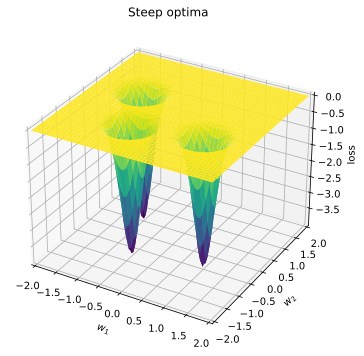

In [35]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * tf.math.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean= 1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean= 0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
plot_surface(comb_func, x_range=(-2,2), y_range=(-2,2), title="Steep optima", ax=ax)
plt.show();

Most of the loss surface has very little to no gradients. However, close to the optima, we have very steep gradients. To reach the minimum when starting in a region with lower gradients, we expect an adaptive learning rate to be crucial. To verify this hypothesis, we can run our three optimizers on the surface:

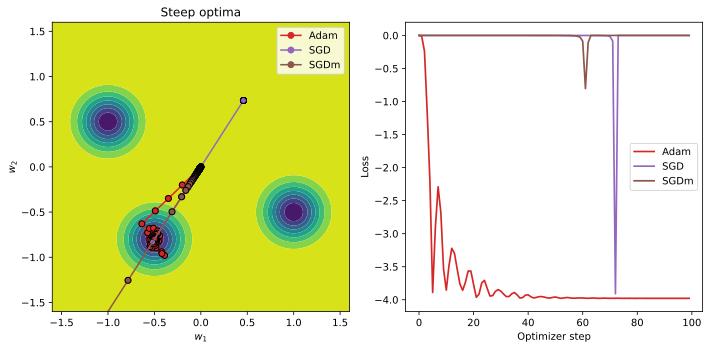

In [76]:
optimizers = {
    'Adam': lambda model: Adam(model, learning_rate=0.2),
    'SGD':  lambda model: SGD(model, learning_rate=0.5),
    'SGDm': lambda model: SGDMomentum(model, learning_rate=1, momentum=0.9),
}

results = plot_optimizer_path(
    optimizers=optimizers, 
    init=[0., 0.], 
    surface=comb_func,
    surface_name='Steep optima',
    x_range=(-1.6, 1.6),
    y_range=(-1.6, 1.6)
)

Plotting the projections on each axis since it is difficult to see SGD from the contour plot:

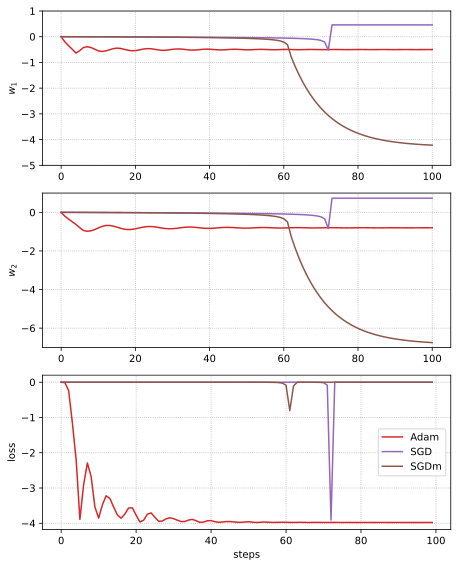

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(6.5, 8))

# Plot x-axis of trajectory of optimizers
for i, optim_name in enumerate(optimizers.keys()):
    n = len(results[optim_name]['path'])
    ax[0].plot(range(n),   results[optim_name]['path'][:, 0], color=f"C{i+3}", label=optim_name)
    ax[1].plot(range(n),   results[optim_name]['path'][:, 1], color=f"C{i+3}", label=optim_name)
    ax[2].plot(range(n-1), results[optim_name]['losses'],     color=f"C{i+3}", label=optim_name)

ax[0].grid(linestyle='dotted')
ax[0].set_ylabel(r"$w_1$")
ax[0].set_ylim(-5, 1)

ax[1].grid(linestyle='dotted')
ax[1].set_ylabel(r"$w_2$")
ax[1].set_ylim(-7, 1)

ax[2].grid(linestyle='dotted')
ax[2].set_xlabel("steps")
ax[2].set_ylabel("loss")
ax[2].legend()

fig.tight_layout()

SGD first takes very small steps until it touches the border of the optimum at around `75` steps around `(-0.5,-0.9)`. Then, the gradient direction changes and pushes the parameters to `(0.5, 0.9)` from which SGD cannot recover anymore (only with many, many steps). A similar problem has SGD with momentum earlier at around `60` steps, only that it continues the direction of the touch of the optimum. The gradients from this time step are so much larger than any other point that the momentum ${\mathbf{m}}_t$ is overpowered by it despite having the factor `0.1`. Finally, Adam is able to converge in the optimum showing the importance of adaptive learning rates.

### What optimizer to take

After seeing the results on optimization, what is our conclusion? Should we always use Adam and never look at SGD anymore? The short answer: no. There are many papers saying that in certain situations, SGD (with momentum) generalizes better where Adam often tends to overfit {cite}`https://doi.org/10.48550/arxiv.1705.08292` {cite}`DBLP:journals/corr/Ruder16`. This is related to the idea of finding wider optima. For instance, see the illustration of different optima below from {cite}`DBLP:journals/corr/KeskarMNST16`:

```{figure} ../../img/flat_vs_sharp_minima.svg
```

The black line represents the training loss surface, while the dotted red line is the test loss. Finding sharp, narrow minima can be helpful for finding the minimal training loss. However, this doesn't mean that it also minimizes the test loss as especially flat minima have shown to generalize better. You can imagine that the test dataset has a slightly shifted loss surface due to the different examples than in the training set. A small change can have a significant influence for sharp minima, while flat minima are generally more robust to this change. 

In the notebook [Inception, ResNet, and DenseNet](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/06-tensorflow-inception.html), we will see that some network types can still be better optimized with SGD and learning rate scheduling than Adam. Nevertheless, Adam is the most commonly used optimizer in deep learning as it usually performs better than other optimizers especially for deep networks.

## Conclusion

In this notebook, we looked at initialization and optimization techniques for neural networks. We have seen that a good initialization has to balance maintaining equal gradient variance as well as the activation variance across layers. This can be achieved with the Xavier initialization for tanh-based networks, and the Kaiming initialization for ReLU-based networks. In optimization, concepts like momentum and adaptive learning rate can help with challenging loss surfaces but don’t guarantee an increase in performance for neural networks.
